# Machine Learning Pipeline for Queen Bee Acoustic Monitoring Using CNN

A complete end-to-end prototype to detect **Queen Bee Presence** from **Hive audio recordings** using a Machine Learning pipeline.

---

## Live Demo (CNN prototype is in progress)
<div class="alert alert-block alert-success">
Note:
You can try the deployed model (Model used Random Forest Classifier in this prototype) and download a sample audio file to test it.

</div>

<span style="display: inline-block;">
  <a href="http://3.109.237.216:5173/">
    <img src="https://img.shields.io/badge/Live-Demo-blue" alt="Live Demo">
  </a>
</span>

<span style="display: inline-block;" >
<a href="https://drive.google.com/drive/folders/1KFmHH304soDKXbLvlohWBJ-qVzudjTgZ?usp=sharing">
    <img src="https://img.shields.io/badge/Google%20Drive-Sample%20Data-blue?logo=google-drive&logoColor=white" alt="Google Drive">
</a>
</span>
    
<span style="display: inline-block;">
<a href="https://github.com/Harsh-1711/BuzzDetect">
  <img src="https://img.shields.io/badge/GitHub-View%20Repository-blue?logo=github" alt="GitHub Repo">
</a>
</span>
<span style="display: inline-block;">
  <a href="https://drive.google.com/file/d/1-SGfCbHHD-mDmvG1dTvz64QDQVDCIDsr/view?usp=sharing" target="_blank">
    <img src="https://img.shields.io/badge/Demo-Video-green?logo=google-drive" alt="Demo Video">
  </a>
</span>

---

This notebook demonstrates a complete pipeline for processing hive audio recordings and applying machine learning to detect the presence of the queen bee. 
It covers audio feature extraction, dataset preparation, model training, evaluation, and inference.

In [15]:
"""
Import necessary libraries for the Queen Bee Detection project.

- os: For file and directory operations.
- numpy: For numerical operations on arrays and matrices.
- matplotlib & seaborn: For data visualization.
- librosa: For audio processing and feature extraction.
"""

import os
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
from tqdm import tqdm
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import keras_tuner as kt

import warnings
warnings.filterwarnings("ignore")

## **1. Data Loading and Exploration**
#### 📌 Objective:
    Load the dataset dataset and plot a graph showing the total no. of dataset for each category.
    
<div class="alert alert-block alert-success">
    Dataset Source:
</div>
        
  - This dataset was originally sourced from https://zenodo.org/records/2667806.
  - It contains labeled audio recordings from beehives for Queen Bee detection.
  - Modified Dataset - https://www.kaggle.com/datasets/harshkumar1711/beehive-audio-dataset-with-queen-and-without-queen

In [4]:
#importing dataset from kaggle
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/Dataset/queenbee_final_model.h5
/kaggle/input/Dataset/spectrograms/present/Hive1 12_06_2018_QueenBee____02_00_00_chunk60.png
/kaggle/input/Dataset/spectrograms/present/Hive1 12_06_2018_QueenBee____02_10_00_chunk37.png
/kaggle/input/Dataset/spectrograms/present/Hive1 12_06_2018_QueenBee____03_00_00_chunk6.png
/kaggle/input/Dataset/spectrograms/present/Hive1 12_06_2018_QueenBee____02_50_00_chunk25.png
/kaggle/input/Dataset/spectrograms/present/Hive1 12_06_2018_QueenBee____02_20_00_chunk37.png
/kaggle/input/Dataset/spectrograms/present/Hive1 12_06_2018_QueenBee____03_40_00_chunk14.png
/kaggle/input/Dataset/spectrograms/present/Hive1 12_06_2018_QueenBee____01_20_00_chunk51.png
/kaggle/input/Dataset/spectrograms/present/Hive1 12_06_2018_QueenBee____04_20_00_chunk18.png
/kaggle/input/Dataset/spectrograms/present/Hive1 12_06_2018_QueenBee____03_10_00_chunk44.png
/kaggle/input/Dataset/spectrograms/present/Hive1 12_06_2018_QueenBee____05_30_00_chunk3.png
/kaggle/input/Dataset/spec

QueenBee Present: 2000 files
QueenBee Absent: 2000 files


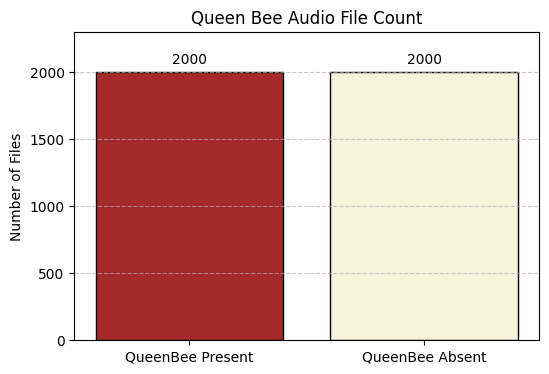

In [5]:

# Load base path
base_path = "/kaggle/input/Dataset/Bee Hive Audios"

# Include spaces prbboperly using raw string or quotes
present_path = os.path.join(base_path, "QueenBee Present")
absent_path = os.path.join(base_path, "QueenBee Absent")

# Count .wav files
present_count = len([f for f in os.listdir(present_path) if f.endswith('.wav')])
absent_count = len([f for f in os.listdir(absent_path) if f.endswith('.wav')])

# Print counts
print(f"QueenBee Present: {present_count} files")
print(f"QueenBee Absent: {absent_count} files")

# Plot the counts
labels = ['QueenBee Present', 'QueenBee Absent']
counts = [present_count, absent_count]

plt.figure(figsize=(6, 4))
plt.ylim(0, 2300) 
bars=plt.bar(labels, counts, color=['brown', 'beige'],edgecolor='black')
plt.grid(axis="y",linestyle="--",alpha=0.7)
for bar in bars:
    x = bar.get_x() + bar.get_width()/2
    y = bar.get_height()
    plt.text(x, y+y ** 0.5, str(y), ha='center', va='bottom', fontsize=10, color='black')
plt.title("Queen Bee Audio File Count")
plt.ylabel("Number of Files")
plt.show()


## **2. Audio Preprocessing and Spectrogram Generation**
#### 📌 Objective:
    This section defines parameters for audio sampling and a function to convert `.wav` audio files into mel spectrogram images. The function performs the following steps:
    - Loads and trims the audio.
    - Normalizes the signal and ensures a fixed length.
    - Generates a mel spectrogram using Librosa.
    - Saves the spectrogram as a `.png` image for use in model training.

This is a key step in preparing audio data for convolutional neural networks (CNNs), which work better with visual inputs.

In [6]:
output_base = "/kaggle/input/Dataset/spectrograms"
os.makedirs(os.path.join(output_base, "present"), exist_ok=True)
os.makedirs(os.path.join(output_base, "absent"), exist_ok=True)


In [ ]:
SAMPLE_RATE = 22050
DURATION = 3  # seconds
SAMPLES_PER_TRACK = SAMPLE_RATE * DURATION

# Function to process and save spectrograms
def preprocess_and_save_spectrogram(audio_path, output_image_path, sr=SAMPLE_RATE, duration=DURATION):
    
    """
    Load an audio file, convert it into a mel spectrogram, and save it as an image.

    Parameters:
    -----------
    audio_path : str
        Path to the input .wav audio file.
    output_image_path : str
        Path where the output spectrogram image will be saved.
    sr : int, optional
        Sampling rate for the audio. Default is 22050 Hz.
    duration : int, optional
        Duration (in seconds) to which the audio will be fixed. Default is 3 seconds.

    Steps:
    ------
    1. Load and trim silence from the audio.
    2. Convert to mono and normalize the waveform.
    3. Pad or truncate to fixed duration.
    4. Generate a mel spectrogram.
    5. Convert the power spectrogram to decibels.
    6. Save the spectrogram as a `.png` image (suitable for CNN input).
    
    Exceptions:
    -----------
    If any error occurs during processing, the function will print an error message.
    """
    
    try:
        y, _ = librosa.load(audio_path, sr=sr)
        y, _ = librosa.effects.trim(y)
        y = librosa.to_mono(y) if y.ndim > 1 else y
        y = librosa.util.normalize(y)

        max_len = sr * duration
        if len(y) > max_len:
            y = y[:max_len]
        else:
            y = np.pad(y, (0, max_len - len(y)))

        # Create mel spectrogram
        S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
        S_dB = librosa.power_to_db(S, ref=np.max)

        # Save as image
        plt.figure(figsize=(2.56, 2.56), dpi=100)
        librosa.display.specshow(S_dB, sr=sr, cmap='magma')
        plt.axis('off')
        plt.tight_layout(pad=0)
        plt.savefig(output_image_path, bbox_inches='tight', pad_inches=0)
        plt.close()
    except Exception as e:
        print(f"Error processing {audio_path}: {e}")


In [6]:
for filename in tqdm(os.listdir(present_path), desc="Processing Present"):
    if filename.endswith('.wav'):
        input_path = os.path.join(present_path, filename)
        output_path = os.path.join(output_base, "present", filename.replace(".wav", ".png"))
        preprocess_and_save_spectrogram(input_path, output_path)

# Process Absent Files
for filename in tqdm(os.listdir(absent_path), desc="Processing Absent"):
    if filename.endswith('.wav'):
        input_path = os.path.join(absent_path, filename)
        output_path = os.path.join(output_base, "absent", filename.replace(".wav", ".png"))
        preprocess_and_save_spectrogram(input_path, output_path)

print("✅ Spectrogram image generation complete.")


Processing Absent: 100%|██████████| 2000/2000 [02:47<00:00, 11.92it/s]

✅ Spectrogram image generation complete.


## **3. Visualizing Spectrogram Distribution Across Classes**

This section analyzes the dataset by counting the number of spectrogram images in each class — "present" and "absent" — and visualizes the distribution using a bar chart.

    Steps performed:
    - Counts `.png` spectrogram files in each class directory.
    - Stores and prints the counts.
    - Plots a bar graph to visualize class balance.
    - Adds numeric labels on top of each bar for clarity.

This helps assess whether the dataset is balanced, which is crucial for model performance in classification tasks.


present: 2000 spectrograms
absent: 2000 spectrograms


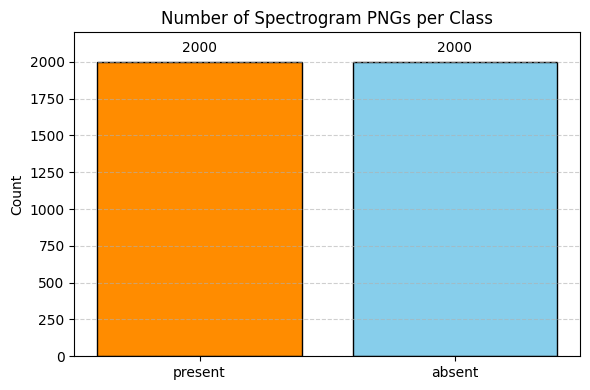

In [22]:

# Spectrogram image path
spectrogram_path = "/kaggle/input/Dataset/spectrograms"

# Define class folders
class_folders = ['present', 'absent']
counts = []

# Count PNG files in each folder
for label in class_folders:
    class_path = os.path.join(spectrogram_path, label)
    count = len([f for f in os.listdir(class_path) if f.endswith('.png')])
    counts.append(count)
    print(f"{label}: {count} spectrograms")

# Plotting
plt.figure(figsize=(6, 4))
bars = plt.bar(class_folders, counts, color=['darkorange', 'skyblue'], edgecolor='black')
plt.ylim(0,2200)
plt.title("Number of Spectrogram PNGs per Class")
plt.ylabel("Count")
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Add count labels on top
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval+yval ** 0.5, str(yval), ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()


## **4. Preparing Data Loaders: Train, Validation, and Test Splits**

This section prepares the spectrogram dataset for training a CNN using TensorFlow's `ImageDataGenerator`.

- **Base Directory**: Points to the location of spectrogram images organized by class.
- **Image Preprocessing**: Rescales pixel values to the [0, 1] range.
- **Splitting Strategy**:
  - **70%** of the data is used for training.
  - The remaining **30%** is further split evenly into **15% validation** and **15% testing**.
- **Generators Created**:
  - `train_gen` for training the model.
  - `val_gen` for tuning hyperparameters and monitoring overfitting.
  - `test_gen` for final performance evaluation.

This setup ensures consistent and reproducible splits with a fixed seed.


In [40]:
# Base directory
data_dir = "/kaggle/input/Dataset/spectrograms"

# Params
IMG_SIZE = (128, 128)
BATCH_SIZE = 32
SEED = 42

# 💾 Data split: 70% train, 15% val, 15% test
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.30)

# 70% Train
train_gen = datagen.flow_from_directory(
    data_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training',
    seed=SEED
)

# Split remaining 30% into 15% val + 15% test
datagen_val_test = ImageDataGenerator(rescale=1./255, validation_split=0.5)

val_gen = datagen_val_test.flow_from_directory(
    data_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training',
    seed=SEED
)

test_gen = datagen_val_test.flow_from_directory(
    data_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation',
    seed=SEED,
    shuffle=False
)


Found 2800 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [32]:
def build_model(hp):
    """
    Builds and compiles a convolutional neural network (CNN) model using hyperparameters 
    provided by Keras Tuner's HyperParameters object.

    The model is designed for binary image classification (e.g., presence of queen bee).

    Hyperparameters tuned:
    - conv_1_filter: Number of filters in the first Conv2D layer (choices: 32, 64)
    - conv_1_kernel: Kernel size for the first Conv2D layer (choices: 3, 5)
    - conv_2_filter: Number of filters in the second Conv2D layer (choices: 64, 128)
    - conv_2_kernel: Kernel size for the second Conv2D layer (choices: 3, 5)
    - dense_units: Number of units in the Dense layer (range: 64 to 256, step: 32)
    - dropout: Dropout rate after Dense layer (range: 0.2 to 0.5, step: 0.1)

    Returns:
        model (tf.keras.Model): Compiled CNN model.
    """
    model = models.Sequential()
    model.add(layers.Conv2D(
        filters=hp.Choice('conv_1_filter', [32, 64]),
        kernel_size=hp.Choice('conv_1_kernel', [3, 5]),
        activation='relu',
        input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)
    ))
    model.add(layers.MaxPooling2D(pool_size=2))

    model.add(layers.Conv2D(
        filters=hp.Choice('conv_2_filter', [64, 128]),
        kernel_size=hp.Choice('conv_2_kernel', [3, 5]),
        activation='relu'
    ))
    model.add(layers.MaxPooling2D(pool_size=2))

    model.add(layers.Flatten())
    model.add(layers.Dense(
        units=hp.Int('dense_units', min_value=64, max_value=256, step=32),
        activation='relu'
    ))
    model.add(layers.Dropout(hp.Float('dropout', 0.2, 0.5, step=0.1)))
    model.add(layers.Dense(1, activation='sigmoid'))

    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

# Tuner setup
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    directory='queenbee_tuner',
    project_name='queen_cnn'
)

tuner.search_space_summary()

# ⏳ Run tuning
tuner.search(train_gen, validation_data=val_gen, epochs=10)

# 🏆 Get best model
best_model = tuner.get_best_models(num_models=1)[0]
best_model.summary()


Trial 5 Complete [00h 02m 24s]
val_accuracy: 0.9994999766349792

Best val_accuracy So Far: 1.0
Total elapsed time: 00h 12m 10s


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 124, 124, 64)        │           4,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 62, 62, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 60, 60, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 115200)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 224)                 │      25,805,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 224)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             225 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 25,883,969 (98.74 MB)

 Trainable params: 25,883,969 (98.74 MB)

 Non-trainable params: 0 (0.00 B)

In [33]:
# Combine train + val
datagen_full = ImageDataGenerator(rescale=1./255, validation_split=0.15)
final_train_gen = datagen_full.flow_from_directory(
    data_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training',
    seed=SEED
)
final_val_gen = datagen_full.flow_from_directory(
    data_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation',
    seed=SEED
)

# Train
history = best_model.fit(
    final_train_gen,
    validation_data=final_val_gen,
    epochs=10
)


Found 3400 images belonging to 2 classes.
Found 600 images belonging to 2 classes.
Epoch 1/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 19s 144ms/step - accuracy: 0.9642 - loss: 0.0844 - val_accuracy: 0.9983 - val_loss: 0.0124
Epoch 2/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 12s 112ms/step - accuracy: 0.9943 - loss: 0.0200 - val_accuracy: 0.9967 - val_loss: 0.0117
Epoch 3/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 12s 114ms/step - accuracy: 0.9981 - loss: 0.0091 - val_accuracy: 0.9933 - val_loss: 0.0310
Epoch 4/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 12s 113ms/step - accuracy: 0.9945 - loss: 0.0180 - val_accuracy: 1.0000 - val_loss: 0.0041
Epoch 5/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 12s 109ms/step - accuracy: 0.9984 - loss: 0.0069 - val_accuracy: 0.9967 - val_loss: 0.0073
Epoch 6/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 12s 108ms/step - accuracy: 0.9902 - loss: 0.0284 - val_accuracy: 0.9950 - val_loss: 0.0120
Epoch 7/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 12s 110ms/step - accuracy: 0.9965 - loss: 0.0096 - val_accuracy: 1.0000 - val_loss: 0.0044


In [35]:
# Save the fine-tuned model
best_model.save("/kaggle/working/queenbee_final_model.h5")

In [36]:
#load the fine-tuned model
from tensorflow.keras.models import load_model

model = load_model("/kaggle/input/Dataset/queenbee_final_model.h5") # change the path if you are using your own trained model


## **5.** **Evaluate Metrics**

* Accuracy, Precision, Recall, F1, ROC AUC  
* Confusion Matrix  
* ROC & PR Curves  
* Test Set Performance Summary

In [58]:
def run_inference(model, test_gen):
    """
    Runs inference on the given test data generator using a trained model.

    Args:
        model (tf.keras.Model): Trained Keras model for binary classification.
        test_gen (ImageDataGenerator): Test data generator with images and labels.

    Returns:
        tuple:
            y_pred (np.ndarray): Binary class predictions (0 or 1).
            y_prob (np.ndarray): Predicted probabilities for the positive class.
            y_true (np.ndarray): Ground truth labels from the test generator.
    """
    test_gen.reset()
    y_prob = model.predict(test_gen, steps=int(np.ceil(test_gen.samples / test_gen.batch_size))).ravel()
    y_pred = (y_prob > 0.5).astype(int)
    return y_pred, y_prob, test_gen.classes

In [59]:
import numpy as np
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score, confusion_matrix,
    classification_report, roc_curve, precision_recall_curve
)
import matplotlib.pyplot as plt
import seaborn as sns

# 📈 Metrics
run_inference(model, test_gen)
acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred)
rec = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
roc_auc = roc_auc_score(y_true, y_prob)
pr_auc = average_precision_score(y_true, y_prob)

print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1 Score:  {f1:.4f}")
print(f"AU-ROC:    {roc_auc:.4f}")
print(f"AU-PRC:    {pr_auc:.4f}")


63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 123ms/step
Accuracy:  0.9930
Precision: 0.9862
Recall:    1.0000
F1 Score:  0.9930
AU-ROC:    1.0000
AU-PRC:    1.0000


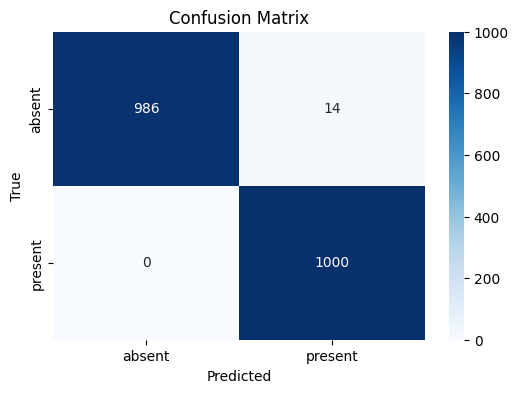

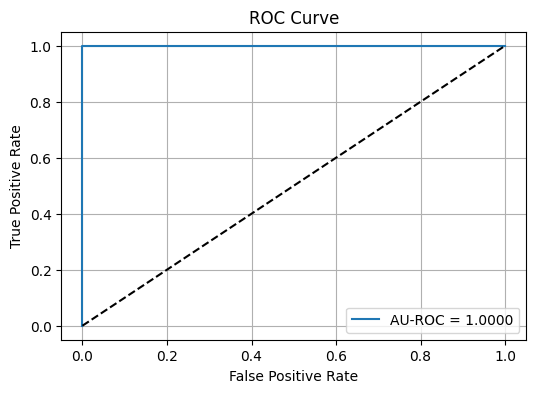

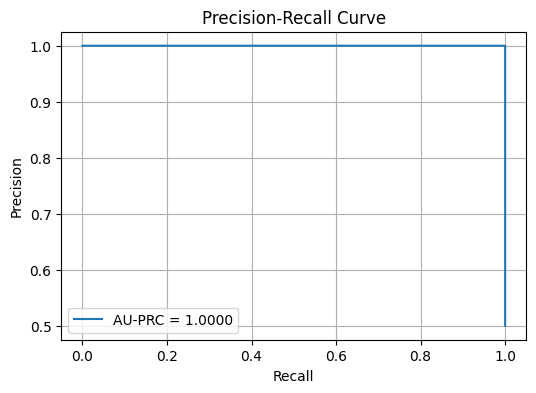

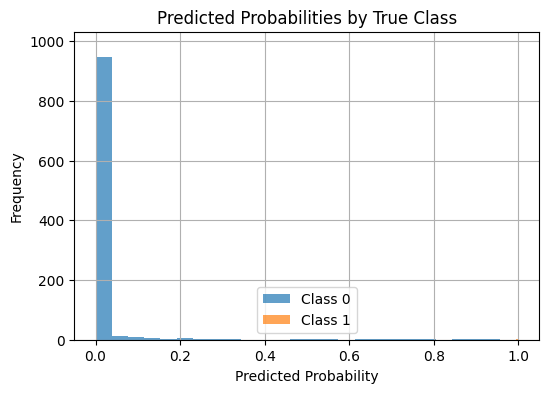

In [54]:
# 📊 Confusion matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=test_gen.class_indices.keys(), yticklabels=test_gen.class_indices.keys())
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

#ROC curve

fpr, tpr, _ = roc_curve(y_true, y_prob)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"AU-ROC = {roc_auc:.4f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid()
plt.show()

#precision recall curve

precision, recall, _ = precision_recall_curve(y_true, y_prob)

plt.figure(figsize=(6, 4))
plt.plot(recall, precision, label=f"AU-PRC = {pr_auc:.4f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.grid()
plt.show()

#Histogram of the predicted model

plt.figure(figsize=(6, 4))
plt.hist(y_prob[y_true == 0], bins=25, alpha=0.7, label='Class 0')
plt.hist(y_prob[y_true == 1], bins=25, alpha=0.7, label='Class 1')
plt.xlabel("Predicted Probability")
plt.ylabel("Frequency")
plt.title("Predicted Probabilities by True Class")
plt.legend()
plt.grid()
plt.show()




In [56]:
print(classification_report(y_true, y_pred, target_names=list(test_gen.class_indices.keys())))


              precision    recall  f1-score   support

      absent       1.00      0.99      0.99      1000
     present       0.99      1.00      0.99      1000

    accuracy                           0.99      2000
   macro avg       0.99      0.99      0.99      2000
weighted avg       0.99      0.99      0.99      2000



### Model Evaluation Commentary
The model demonstrates excellent performance with an **overall accuracy of 99%**. Both classes — "absent" and "present" — have near-perfect **precision, recall, and F1-scores (0.99)**, indicating:

**High precision**: Very few false positives.

**High recall**: Nearly all relevant instances were correctly identified.

**Balanced performance**: Consistent metrics across both classes, confirmed by the macro and weighted averages.

## **6. Prediction and Audio Feature Visualization**
### 📌 Objective:
Visualize key audio features from a sound signal to better understand the characteristics of the data.

#### Features Plotted:
    - Raw audio waveform
    - Mel-spectrogram input to CNN
    - Model prediction probabilities (Queen Present/Absent)
    - Audio statistics (duration, RMS energy, zero-crossing rate, etc.)

In [10]:
def visualize_audio_prediction(audio_path, model):
    """
    Create essential visualizations for audio CNN prediction
    """
    # Load audio
    y, sr = librosa.load(audio_path, sr=SR)
    
    # Create mel-spectrogram
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
    S_dB = librosa.power_to_db(S, ref=np.max)
    
    # Get model input (spectrogram image)
    input_data = audio_to_spectrogram_image(audio_path, model)
    
    # Get prediction
    prediction = model.predict(input_data)
    queen_prob = float(prediction[0][0])
    label = "Queen Present" if queen_prob >= 0.5 else "Queen Absent"
    confidence = queen_prob if queen_prob >= 0.5 else (1 - queen_prob)
    
    # Create visualization
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle(f'Audio Analysis: {audio_path.split("/")[-1]}', fontsize=16, fontweight='bold')
    
    # 1. Raw Waveform
    axes[0, 0].plot(np.linspace(0, len(y)/sr, len(y)), y, color='blue', alpha=0.7)
    axes[0, 0].set_title('Raw Audio Waveform', fontsize=14, fontweight='bold')
    axes[0, 0].set_xlabel('Time (seconds)')
    axes[0, 0].set_ylabel('Amplitude')
    axes[0, 0].grid(True, alpha=0.3)
    
    # 2. Mel-Spectrogram (what CNN sees)
    im = axes[0, 1].imshow(S_dB, aspect='auto', origin='lower', cmap='magma')
    axes[0, 1].set_title('Mel-Spectrogram (CNN Input)', fontsize=14, fontweight='bold')
    axes[0, 1].set_xlabel('Time Frames')
    axes[0, 1].set_ylabel('Mel Frequency Bins')
    plt.colorbar(im, ax=axes[0, 1], label='Power (dB)')
    
    # 3. Prediction Results
    categories = ['Queen Absent', 'Queen Present']
    probabilities = [1 - queen_prob, queen_prob]
    colors = ['red' if p == max(probabilities) else 'lightcoral' for p in probabilities]
    
    bars = axes[1, 0].bar(categories, probabilities, color=colors, alpha=0.8, edgecolor='black')
    axes[1, 0].set_title('Model Predictions', fontsize=14, fontweight='bold')
    axes[1, 0].set_ylabel('Probability')
    axes[1, 0].set_ylim(0, 1)
    axes[1, 0].grid(True, alpha=0.3, axis='y')
    
    # Add probability labels on bars
    for bar, prob in zip(bars, probabilities):
        height = bar.get_height()
        axes[1, 0].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                       f'{prob:.3f}', ha='center', va='bottom', fontweight='bold')
    
    # 4. Audio Statistics
    axes[1, 1].axis('off')
    duration = len(y) / sr
    max_amplitude = np.max(np.abs(y))
    rms_energy = np.sqrt(np.mean(y**2))
    zero_crossings = np.sum(np.diff(np.sign(y)) != 0) / len(y)
    
    stats_text = f"""
    Audio Statistics:
    
    Duration: {duration:.2f} seconds
    Sample Rate: {sr} Hz
    Max Amplitude: {max_amplitude:.4f}
    RMS Energy: {rms_energy:.4f}
    Zero Crossing Rate: {zero_crossings:.4f}
    
    Prediction Results:
    
    Final Prediction: {label}
    Confidence: {confidence*100:.2f}%
    
    Queen Present Prob: {queen_prob:.3f}
    Queen Absent Prob: {1-queen_prob:.3f}
    """
    
    axes[1, 1].text(0.1, 0.9, stats_text, transform=axes[1, 1].transAxes,
                   fontsize=12, verticalalignment='top',
                   bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray", alpha=0.8))
    
    plt.tight_layout()
    plt.show()
    
    return {
        'prediction': label,
        'confidence': confidence,
        'queen_probability': queen_prob,
        'duration': duration,
        'audio_stats': {
            'max_amplitude': max_amplitude,
            'rms_energy': rms_energy,
            'zero_crossing_rate': zero_crossings
        }
    }

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


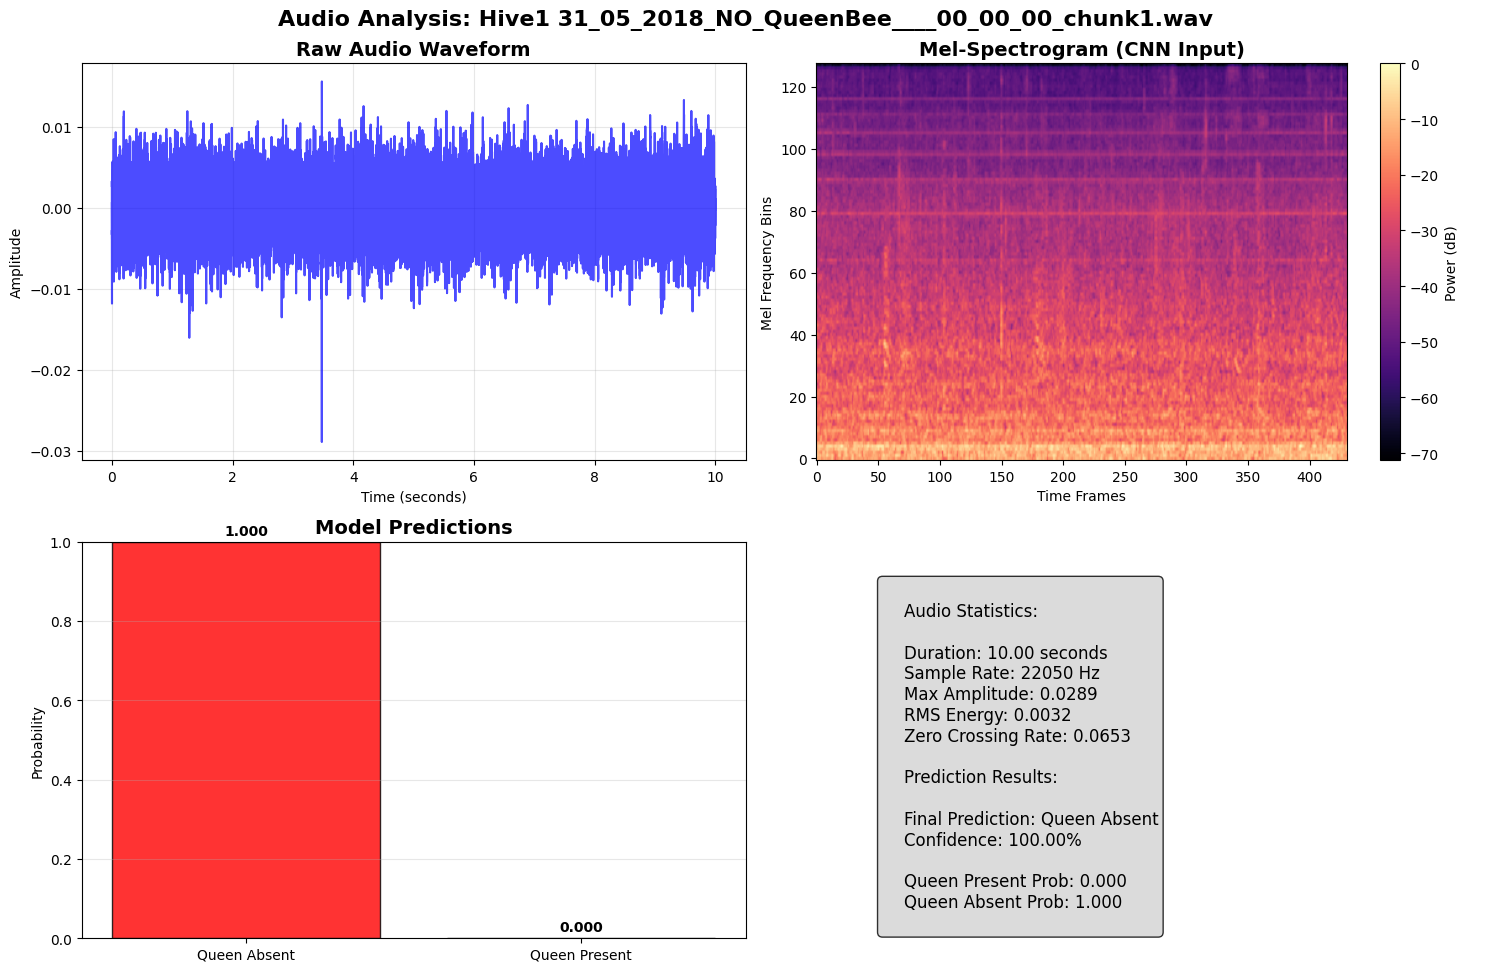


PREDICTION SUMMARY
File: Hive1 31_05_2018_NO_QueenBee____00_00_00_chunk1.wav
Prediction: Queen Absent
Confidence: 100.00%
Audio Duration: 10.00 seconds


In [13]:
from PIL import Image
import io

# --- Parameters (must match training setup) ---
IMG_SIZE = (128, 128)  # your model's input size
SR = 22050  # sampling rate used during training

# --- Function to process a .wav file into spectrogram image ---
def audio_to_spectrogram_image(audio_path,model=None):
    y, sr = librosa.load(audio_path, sr=SR)
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
    S_dB = librosa.power_to_db(S, ref=np.max)

    # Plot to image in memory
    fig = plt.figure(figsize=(2, 2), dpi=64)  # ~128x128
    librosa.display.specshow(S_dB, sr=sr, cmap='magma')
    plt.axis('off')
    buf = io.BytesIO()
    plt.savefig(buf, format='png', bbox_inches='tight', pad_inches=0)
    plt.close(fig)
    buf.seek(0)

    # Load image and resize
    img = Image.open(buf).convert('RGB').resize(IMG_SIZE)
    img_array = np.array(img) / 255.0  # Normalize like training
    img_array = np.expand_dims(img_array, axis=0)  # Shape: (1, 128, 128, 3)
    return img_array

# --- Predict ---
audio_file_path = "/kaggle/input/Dataset/Bee Hive Audios/QueenBee Absent/Hive1 31_05_2018_NO_QueenBee____00_00_00_chunk1.wav" 
run_inference(model,test_gen)
input_data = audio_to_spectrogram_image(audio_file_path)

results = visualize_audio_prediction(audio_file_path, model)

print(f"\n{'='*50}")
print("PREDICTION SUMMARY")
print(f"{'='*50}")
print(f"File: {audio_file_path.split('/')[-1]}")
print(f"Prediction: {results['prediction']}")
print(f"Confidence: {results['confidence']*100:.2f}%")
print(f"Audio Duration: {results['duration']:.2f} seconds")
print(f"{'='*50}")
